In [186]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from scipy import signal
import os
import warnings
warnings.filterwarnings('ignore')

In [190]:
#L
#W
#dId/dVg=mobility*Cox*(W/L)*Vds

# names1=['Vd','Vg','Id','Is','absId']
names2=['Vg','Vd','Ig','Id','Is','absId','absIg']
################################################
#parameter
period=21 #cycle period
W=[2]*10 #um
L=4 #um
# Vds=abs(data.iloc[5,1:2]) #V
Cox=float(3.9*8.854*1e-12/(90*1e-9)) #F/m^2

In [352]:
#Data Processing functions
def monotonicStack(nums, chtype):
    # to make sure the slope is always monotonic decreasing for p-type or
    # increasing for n-type
    stack = []
    for i in range(len(nums)):
        if not stack:
            stack.append(nums[i])
        if chtype == 'n' or 'N':
            if stack and stack[-1] > nums[i]:
                stack.append(nums[i])
        if chtype == 'p' or 'P':
            if stack and stack[-1] > nums[i]:
                stack.append(nums[i])
    return stack

def getslope(Ids,Vg):
    slopeCollection=[]
    for i in range(1,len(Ids)):
        try:
            slope=abs((Ids[i-1]-Ids[i])/(Vg[i-1]-Vg[i]))
            slopeCollection.append(slope)
        except:
            slopeCollection.append(0)
    return [slopeCollection,max(slopeCollection)]

#this is directly extract linear region from Id-Vg
def getMobility1(W,L,Vds,Cox,Vg_range,chtype):
    Vg=data.iloc[Vg_range:Vg_range+period,:1].T.values[0]
    Ids=data.iloc[Vg_range:Vg_range+period,-2].values #A
    VgIds=pd.DataFrame({'Ids':Ids,'Vg':Vg})
    #use montonic queue to store only monotonic decreaseing datafor p-type device
    Ids=monotonicStack(Ids,chtype)
    Vg_monotone=[]
    for current in Ids:
        Vg_monotone.append(VgIds.loc[VgIds['Ids']==current,'Vg'].iloc[0])
    Vg=Vg_monotone
    mu=getslope(Ids,Vg)[1]*L/(Cox*W*Vds).values[0]*1e3
    return mu

def extractVt1():
    pass

#extract mobility by first ploting gm-Vg, get the max gm and use the following equation: 
    #transconductance gm: di/dv
    #sliding window to extract slope

def getMobility2(W,L,Vds,Cox,Vg_range,window_size=7,fitting_factor=3):
    
    Vg=data.iloc[Vg_range+period*0:Vg_range+period*2,:1].T.values[0]
    Ids=data.iloc[Vg_range+period*0:Vg_range+period*2,-2].values #A
    gm=getslope(Ids,Vg)[0]
    gm=[math.log10(abs(x)) for x in gm if x !=float('inf')]
    gm=signal.savgol_filter(gm,window_size,fitting_factor)
    newVg=np.concatenate((Vg[1:period],Vg[period+1:]),axis=None)
    df=pd.DataFrame({'gm':gm,'Vg':newVg})
    df=df[df.gm!=float('inf')]
    sns.set(font_scale = 2)
    #find the maximum gm
    #need to improve this part 
    maxGm=gm[:period].max()
    mu=(10**maxGm)*L/(Cox*W[0]*Vds).values[0]*1e3
    return mu,newVg,gm

def extractVt2():
    pass

def gm_vg_plot(Vg_range,newVg,gm):
#     Vg=data.iloc[Vg_range+period*0:Vg_range+period*2,:1].T.values[0]
#     Ids=data.iloc[Vg_range+period*0:Vg_range+period*2,-2].values #A
#     gm=getslope(Ids,Vg)[0]
#     gm=[math.log10(abs(x)) for x in gm if x !=float('inf')]
#     gm=signal.savgol_filter(gm,7,3)
#     newVg=np.concatenate((Vg[1:period],Vg[period+1:]),axis=None)
    df=pd.DataFrame({'gm':gm,'Vg':newVg})
    df=df[df.gm!=float('inf')]
    sns.set(font_scale = 2)
    #plotting part
    sns.set_style('whitegrid')
    fig,ax=plt.subplots(ncols=2,figsize=(4,4))
    #-50-50
    plt.subplots_adjust(left=0,right=4)
    sns.regplot(x='Vg',y='gm',data=df.iloc[:period,:],scatter_kws={"s": 180},color='red',fit_reg=False,ax=ax[0])
    ax[0].set_title('gm-Vg reverse',fontsize=14)
    ax[0].set_xlabel('Vg (V)',fontsize=18)
    ax[0].set_ylabel('gm',fontsize=18)
    #50-(-50)
    sns.regplot(x='Vg',y='gm',data=df.iloc[period:,:],scatter_kws={"s": 180},color='grey',fit_reg=False,ax=ax[1])
    ax[1].set_title('gm-Vg forward',fontsize=14)
    ax[1].set_xlabel('Vg (V)',fontsize=18)
    ax[1].set_ylabel('gm',fontsize=18)  

def IVPlot(data,scale,title):   
    lowVds=data.iloc[:2*period,:]
    lowVds_upperbound=data.iloc[:2*period,5:6].max().values[0]
    lowVds_lowerbound=data.iloc[:2*period,5:6].min().values[0]
    highVds=data.iloc[2*period+1:,:]
    highVds_upperbound=data.iloc[2*period+1:,5:6].max().values[0]
    highVds_lowerbound=data.iloc[2*period+1:,5:6].min().values[0]
    sns.set(font_scale = 2)
    sns.set_style('whitegrid')
    fig,ax=plt.subplots(ncols=2,figsize=(6,6))
    plt.subplots_adjust(left=0,right=3)
    sns.regplot(x='Vg',y='absId',data=data.iloc[:2*period,:],scatter_kws={"s": 180},fit_reg=False,ax=ax[0])
    ax[0].set_title('{}: Vds= {}V'.format(title,lowVds['Vd'][0]),fontsize=14)
    ax[0].set_ylim(0,lowVds_upperbound*1.2)
    ax[0].set_xlabel('Vg (V)',fontsize=18)
    ax[0].set_ylabel('Ids (A)',fontsize=18)
    sns.regplot(x='Vg',y='absId',data=data.iloc[2*period+1:,:],scatter_kws={"s": 180},fit_reg=False,ax=ax[1])
    ax[1].set_title('{}: Vds= {}V'.format(title,highVds['Vd'][2*period+1]),fontsize=14)
    ax[1].set_ylim(0,highVds_upperbound*1.2)
    ax[1].set_xlabel('Vg (V)',fontsize=18)
    ax[1].set_ylabel('Ids (A)',fontsize=18)
    
    #return [highVds_upperbound,highVds_lowerbound]

In [354]:
#file reading part
def run1():
    folder="d1\\f4\\data"
    csv=[]
    mu=[]
    on_off_ratio=[]
    Vg_range=0 #where data starts 
    dir=os.path.join("c:\\Users\\GSJ\\Desktop","{}".format(folder))
    for root,dirs,files in os.walk(dir):
        for file in files:
            if file[-1]=='v':
                csv.append(file)

    for idx,file in enumerate(csv[:]):
        rawdata=pd.read_csv(r'C:\Users\GSJ\Desktop\d1\f4\data\{}'.format(file),skiprows=259)
        data=rawdata.iloc[Vg_range:,1:8]
        data = data.apply(pd.to_numeric, errors='coerce')
        data.columns=names2
        data.reset_index()

        IVPlot(data,1.2,file)
        temp_on_off_ratio=0
        for i in range(1):
            Vds=-(data.iloc[period*i,1:2]) #V
            tempMu=getMobility(W[idx],L,Vds,Cox,(period*i),'p')
            #print('test',i,tempMu)
            on_current=data.iloc[period*(i+1):period*(i+2),5:6].max().values[0]
            off_current=data.iloc[period*(i+1):period*(i+2),5:6].min().values[0]
            temp_on_off_ratio=max(temp_on_off_ratio,abs(on_current/off_current))
            #print(i,Vds,tempMu)
            mu.append(tempMu)
        if temp_on_off_ratio<1e4:
            on_off_ratio.append(temp_on_off_ratio)
        else:
            on_off_ratio.append(0)
    print('\n')
    mu_df=pd.DataFrame(mu)
    onOff_df=pd.DataFrame(on_off_ratio[:])

##################################################
def run2():
    pass
    

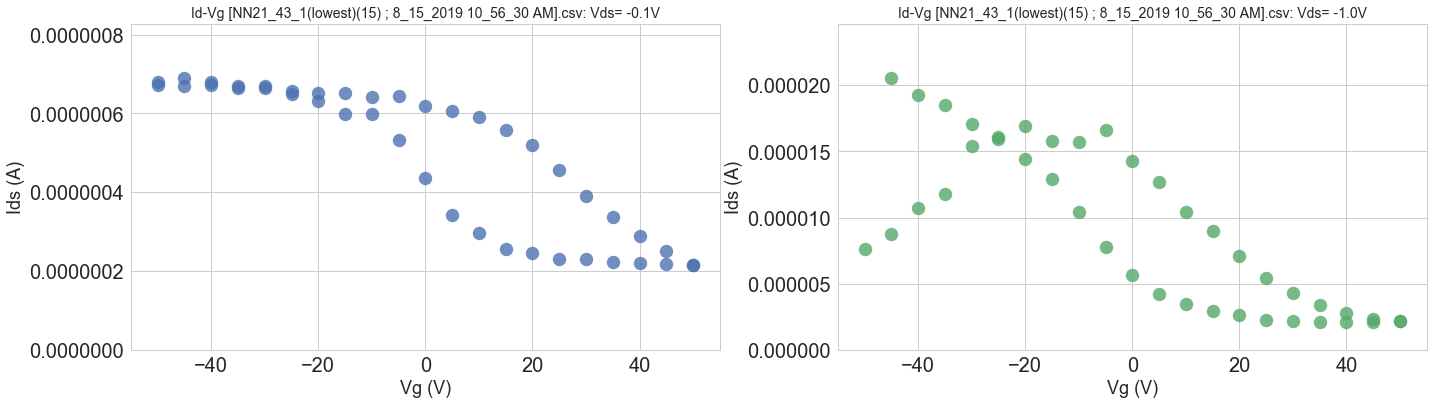

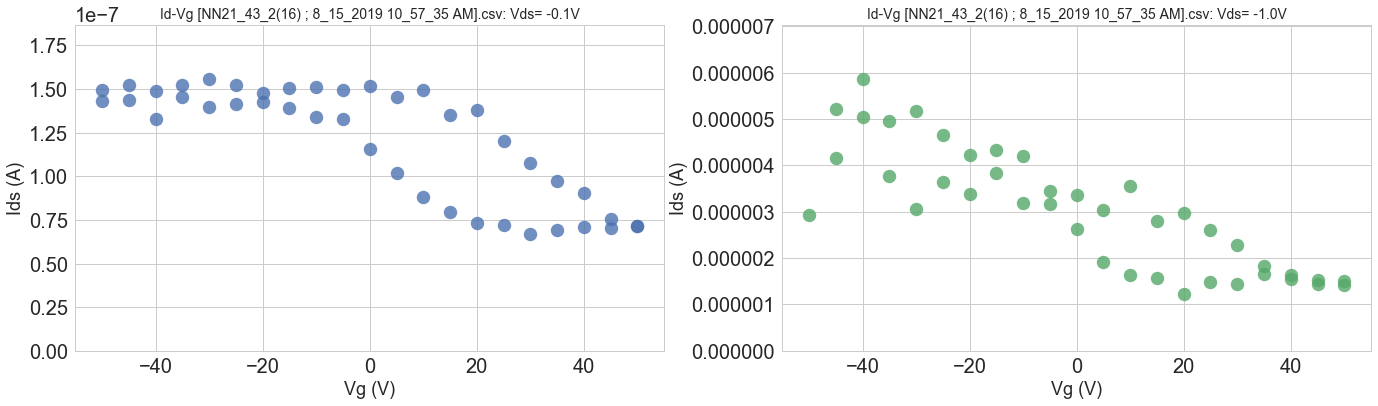

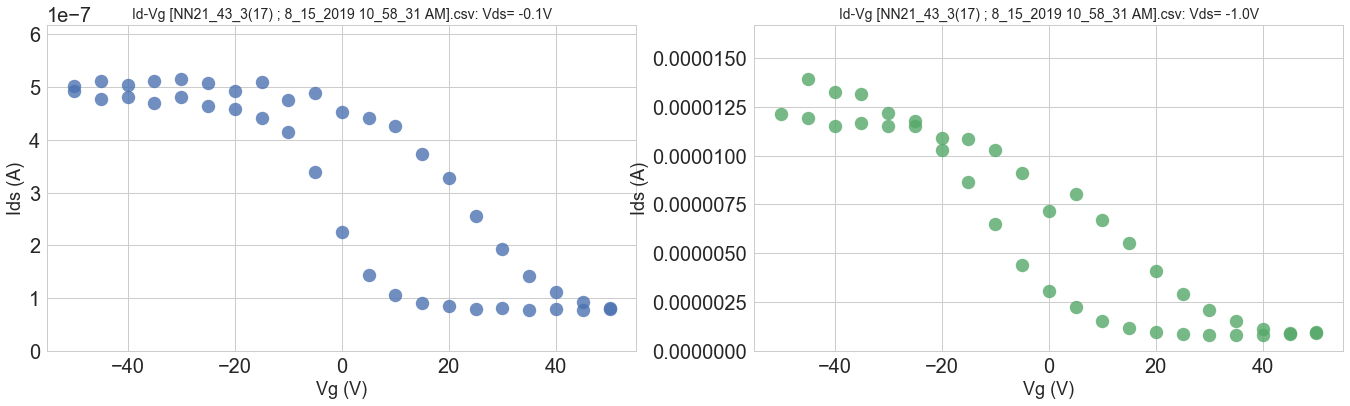

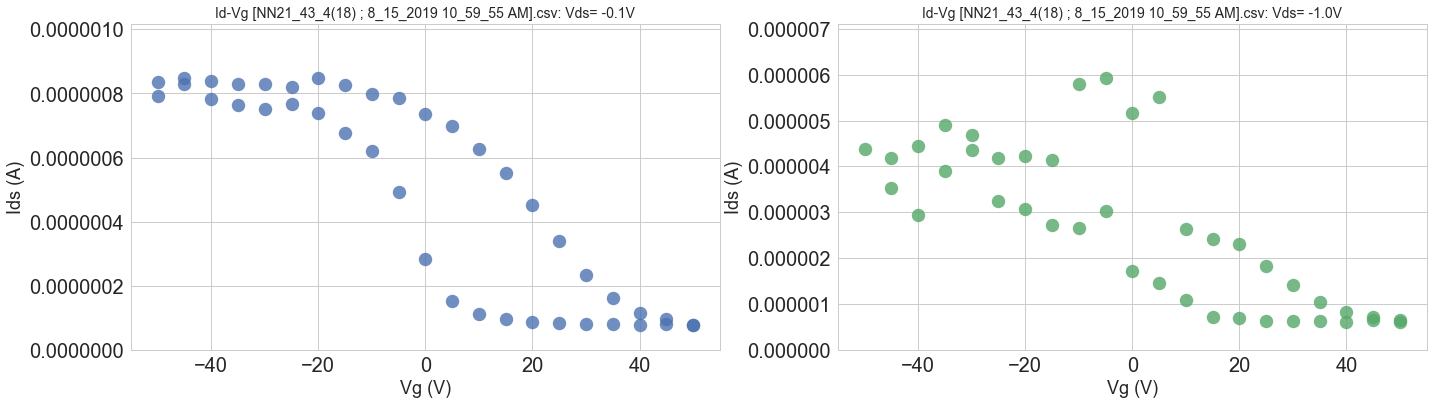

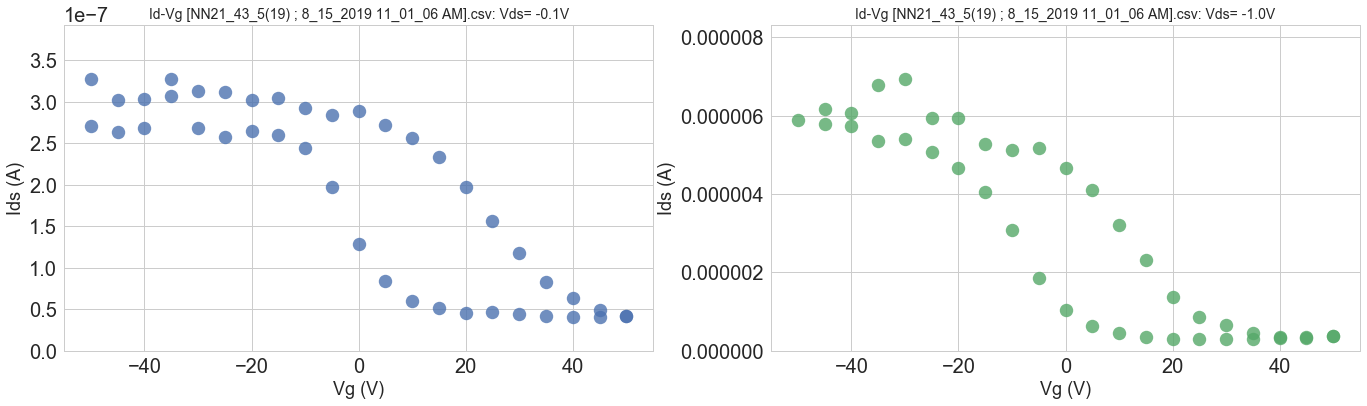

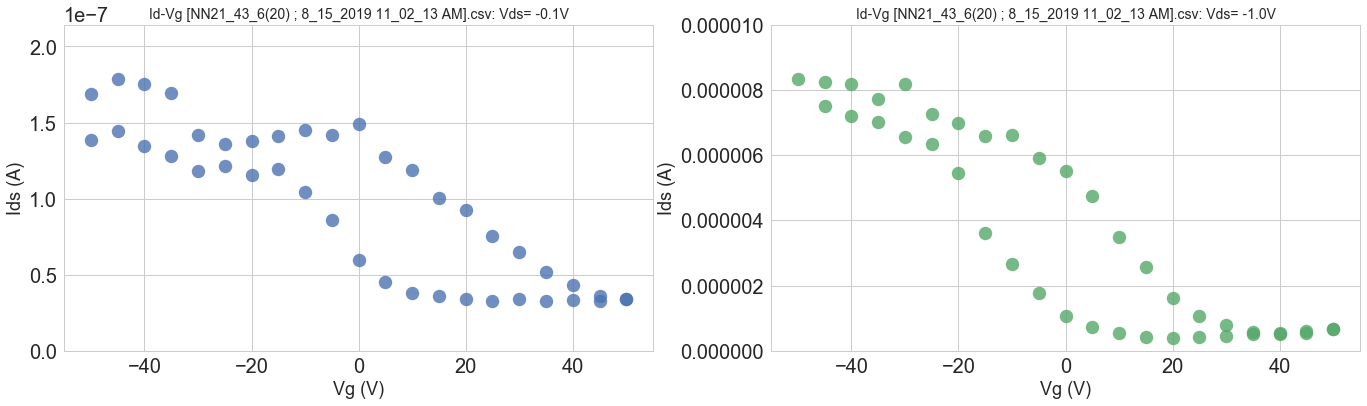

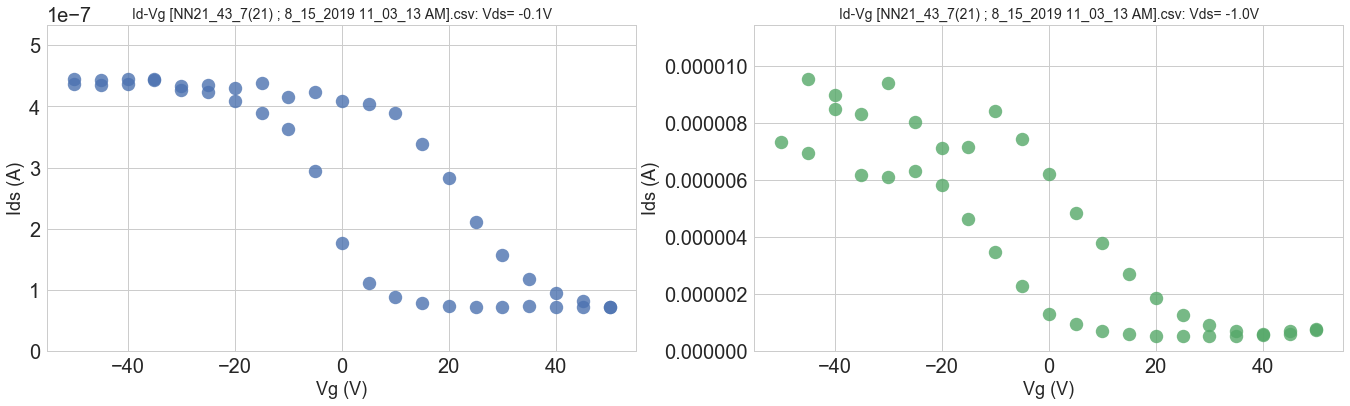

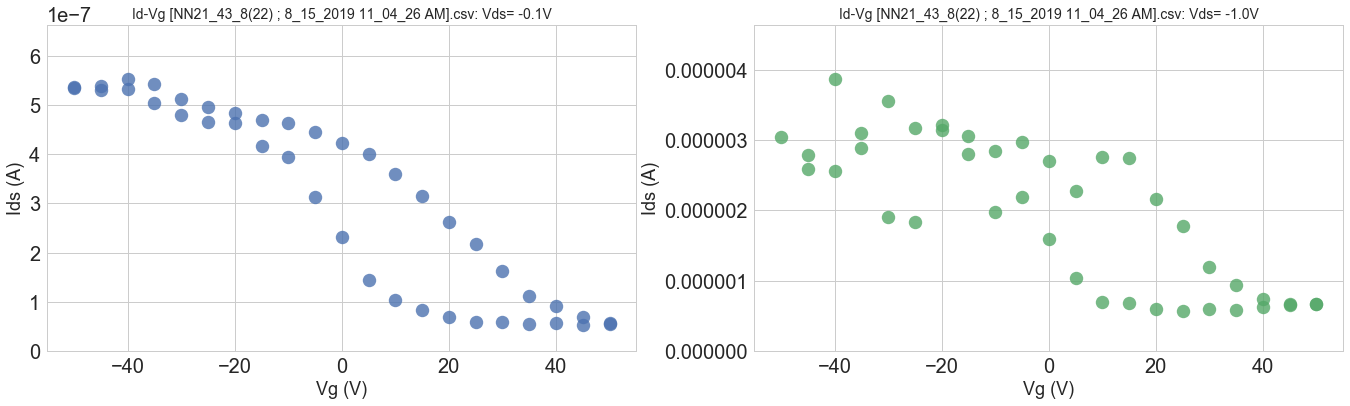

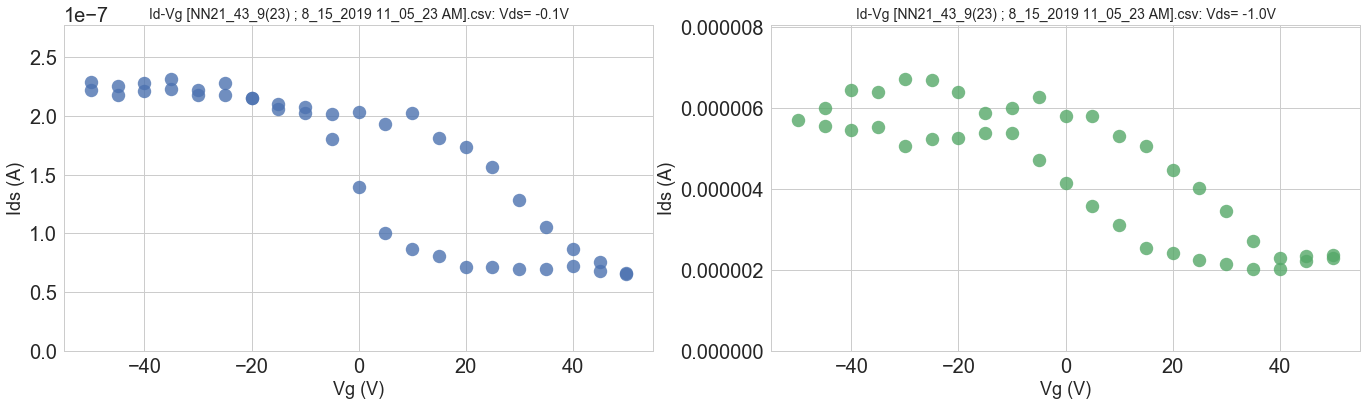

In [355]:
run1()

In [329]:
# #plot them together with double-Y axis
# #data file: mu, on_off_ratio
# mu_df.columns=['Field Effect Mobility cm^2/vs']
# onOff_df.columns=['On-Off Ratio']
# fig,ax1=plt.subplots()
# width=0.4
# bar1=mu_df.plot(kind='bar',color='blue',ax=ax1,position=1,width=width,legend=False)
# ax2 = ax1.twinx()
# bar2=onOff_df.plot(kind='bar',color='red',ax=ax2,position=0,width=width)
# ax1.set_ylabel('Mobility')
# ax2.set_ylabel('On-Off Ratio')

          0
0  0.996681
1  0.178902
2  1.188928
3  2.191239
4  0.714775
5  0.270607
6  1.227711
7  0.901600
8  0.422026


Text(0,0.5,'Field Effect Mobility cm^2/vs')

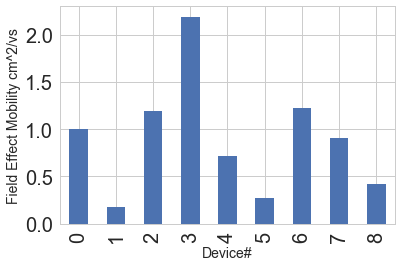

In [351]:
#plot mobility
print(mu_df)
ax=mu_df.iloc[:,:].plot(kind='bar',legend=False)
ax.set_xlabel('Device#',fontsize=14)
ax.set_ylabel('Field Effect Mobility cm^2/vs',fontsize=14)

Text(0,0.5,'On-Off Ratio')

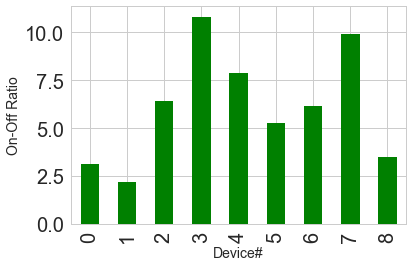

In [195]:
#plot on-off ratio
onOff_df=pd.DataFrame(on_off_ratio[:])
ax1=onOff_df.plot(kind='bar',color='green',legend=False)
ax1.set_xlabel('Device#',fontsize=14)
ax1.set_ylabel('On-Off Ratio',fontsize=14)

         Field Effect Mobility cm^2/vs  On_Off_Ratio
Device#                                             
0                           191.412834      1.735948
1                            99.105142      1.176315


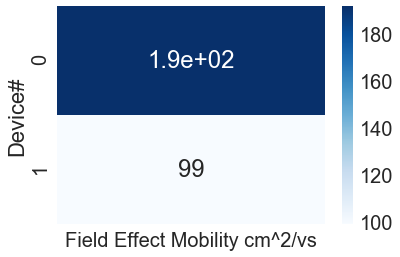

In [8]:
#do heatmap

#data source: onOff_df,mu_df
mu_df.columns=['Field Effect Mobility cm^2/vs']
mu_df.index.names=['Device#']
onOff_df.columns=['On_Off_Ratio']
onOff_df.index.names=['Device#']

#join the dataframe
result = pd.concat([mu_df, onOff_df], axis=1, sort=False)
print(result)
sns.heatmap(mu_df,cmap="Blues",annot=True)
#sns.jointplot(x='Mobility',y='On_Off_Ratio',kind='scatter',color='skyblue',data=result)

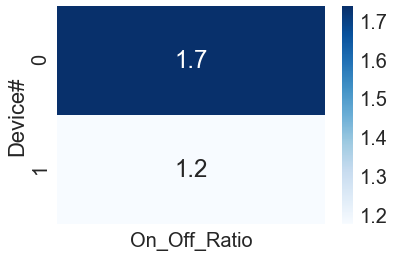

In [9]:
sns.heatmap(onOff_df,cmap="Blues",annot=True)

## Debugging code

In [19]:
#need to solve the not monotonic decreasing in Id,Vg PROBLEM
def monotonicStack(nums, type):
    # to make sure the slope is always monotonic decreasing for p-type or
    # increasing for n-type
    stack = []
    for i in range(len(nums)):
        if not stack:
            stack.append(nums[i])
        if type == 'n' or 'N':
            if stack and stack[-1] > nums[i]:
                stack.append(nums[i])
        if type == 'p' or 'P':
            if stack and stack[-1] > nums[i]:
                stack.append(nums[i])
    return stack

def getslope(Ids,Vg):
    tempMu=[]
    gm=[]
    for i in range(1,len(Ids)-1):
        try:
            slope=(Ids[i-1]-Ids[i])/(Vg[i]-Vg[i-1])
            mu=slope*L/(Cox*W[0]*Vds).values[0]*1e3
            tempMu.append(mu)
        except:
            tempMu.append(0)
    return [max(tempMu),gm]
    
    
def getMobilityTest(W,L,Vds,Cox,Vg_range,chtype):
    Vg=data.iloc[Vg_range:Vg_range+period,:1].T.values[0]
    Ids=data.iloc[Vg_range:Vg_range+period,-2].values #A
    VgIds=pd.DataFrame({'Ids':Ids,'Vg':Vg})
    #use montonic queue to store only monotonic decreaseing datafor p-type device
    Ids=monotonicStack(Ids,chtype)
    Vg_monotone=[]
    for current in Ids:
        Vg_monotone.append(VgIds.loc[VgIds['Ids']==current,'Vg'].iloc[0])
    Vg=Vg_monotone
    mu=getslope(Ids,Vg)[0]

   Vg   Vd            Ig        Id        Is     absId         absIg
0 -50 -0.1 -1.190000e-11 -0.000211  0.000210  0.000211  1.190000e-11
1 -45 -0.1 -1.230000e-11 -0.000193  0.000193  0.000193  1.230000e-11
2 -40 -0.1  4.330000e-12 -0.000180  0.000179  0.000180  4.330000e-12
3 -35 -0.1  1.310000e-11 -0.000169  0.000168  0.000169  1.310000e-11
4 -30 -0.1  1.840000e-12 -0.000159  0.000160  0.000159  1.840000e-12
####################
mobility:  None


Text(0,0.5,'Ids (mA)')

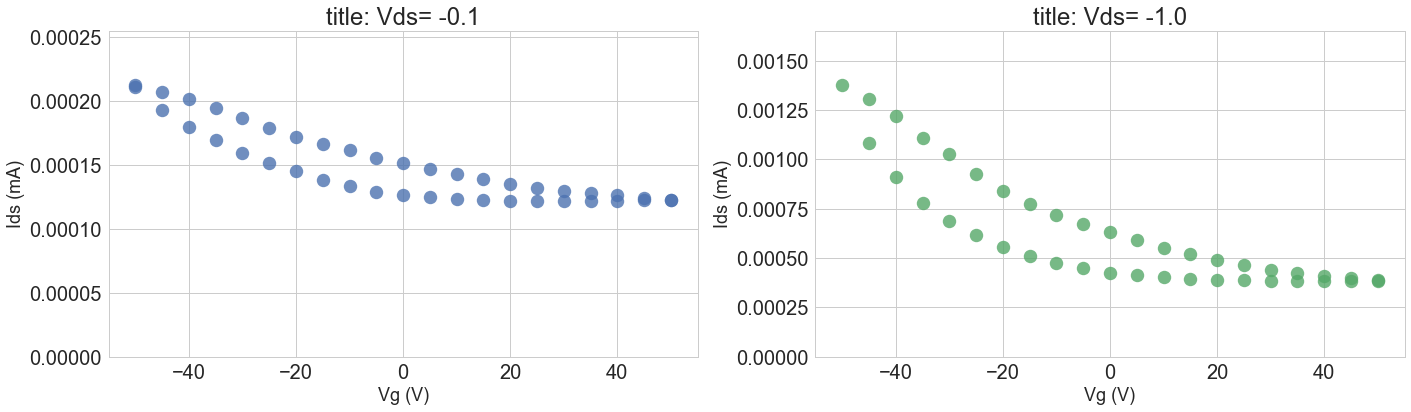

In [21]:
# #load the data (debug)
names2=['Vg','Vd','Ig','Id','Is','absId','absIg']
rawdata=pd.read_csv(r'C:\Users\GSJ\Desktop\test.csv',skiprows=258)
data=rawdata.iloc[:,1:8]
data = data.apply(pd.to_numeric, errors='coerce')
data.columns=names2
data.reset_index()
print(data.head())
print('#'*20)
mu=getMobilityTest(W,L,Vds,Cox,(period*i),'p')

############
#IVPlot(data)
lowVds=data.iloc[:2*period,:]
lowVds_upperbound=data.iloc[:2*period,5:6].max().values[0]
lowVds_lowerbound=data.iloc[:2*period,5:6].min().values[0]
highVds=data.iloc[2*period+1:,:]
highVds_upperbound=data.iloc[2*period+1:,5:6].max().values[0]
highVds_lowerbound=data.iloc[2*period+1:,5:6].min().values[0]
sns.set(font_scale = 2)
sns.set_style('whitegrid')
fig,ax=plt.subplots(ncols=2,figsize=(6,6))
plt.subplots_adjust(left=0,right=3)
sns.regplot(x='Vg',y='absId',data=data.iloc[:2*period,:],scatter_kws={"s": 180},fit_reg=False,ax=ax[0])
ax[0].set_title('title: Vds= {}'.format(lowVds['Vd'][0]))
ax[0].set_ylim(0,lowVds_upperbound*1.2)
ax[0].set_xlabel('Vg (V)',fontsize=18)
ax[0].set_ylabel('Ids (mA)',fontsize=18)
sns.regplot(x='Vg',y='absId',data=data.iloc[2*period+1:,:],scatter_kws={"s": 180},fit_reg=False,ax=ax[1])
ax[1].set_title('title: Vds= {}'.format(highVds['Vd'][2*period+1]))
ax[1].set_ylim(0,highVds_upperbound*1.2)
ax[1].set_xlabel('Vg (V)',fontsize=18)
ax[1].set_ylabel('Ids (mA)',fontsize=18)

In [22]:
#file export
#from dataframe to local CSV